# Course Recommendation Engine

## Introduction

As college students, course registration is an important process to secure our favourite & necessary courses for graduation. The main issue that occurs across many colleges is the time-consuming cycle of checking the requirements for the course, seeing if my interests match the paragraph-long description and hitting the register button. To at least partly solve this issue, what if we created a tool that recommends courses based on student's current profile as parameters (i.e. courses taken, interests, etc.). Specifically, this recommendation engine primarily focuses on recomendation via Pre-requisites & Course Description.

*This notebook includes:*
- EDA & Data cleaning
- Proprocessing the input texts using spacy and nltk libraries
- Exploring dimensionality reduction techniques 
- Clustering using various algorithms, optimizing number of clusters using Elbow plots 
- Testing cluster metrics using scoring system 
- Implementation of Recommendation function 

*About the data:*


This data was webscraped from the UBC Computer Science course database page. Using a simple Python script with BeautifulSoup, extracting useful information such as course code, name, and description was done conveniently.

<strong> Import necessary libraries </strong>

Important libraries:
- TfidfVectorizer: Gathers all the words in a list of documents and weights them to see how frequent they are.
- word_tokenize: Splits a phrase into individual words
- WordNetLemmatizer: Applies lemmatization to words

In [218]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import RobustScaler
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import spacy 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np

In [219]:
nlp = spacy.load('en_core_web_sm')

### 1. EDA on Course Information

In [220]:
course_df = pd.read_csv("./coursedata/course_data.csv")

In [221]:
course_df.head(5)

,Unnamed: 0,code,name,description
0,0,CPSC_V 100,Computational Thinking,Meaning and impact of computational thinking. ...
1,1,CPSC_V 103,Introduction to Systematic Program Design,Computation as a tool for systematic problem s...
2,2,CPSC_V 107,Systematic Program Design,Fundamental computation and program structures...
3,3,CPSC_V 110,"Computation, Programs, and Programming",Fundamental program and computation structures...
4,4,CPSC_V 121,Models of Computation,Physical and mathematical structures of comput...


In [222]:
course_df.drop(columns=[course_df.columns[0]], inplace=True)

In [223]:
course_df.head()

,code,name,description
0,CPSC_V 100,Computational Thinking,Meaning and impact of computational thinking. ...
1,CPSC_V 103,Introduction to Systematic Program Design,Computation as a tool for systematic problem s...
2,CPSC_V 107,Systematic Program Design,Fundamental computation and program structures...
3,CPSC_V 110,"Computation, Programs, and Programming",Fundamental program and computation structures...
4,CPSC_V 121,Models of Computation,Physical and mathematical structures of comput...


In [224]:
course_df.fillna('', inplace=True)

In [225]:
course_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   code         110 non-null    object
 1   name         110 non-null    object
 2   description  110 non-null    object
dtypes: object(3)
memory usage: 2.7+ KB


In [226]:
def categorize_course(name):
    first_digit = int(name.split(" ")[1][0])
    return first_digit

course_df["level"] = course_df["code"].apply(categorize_course)

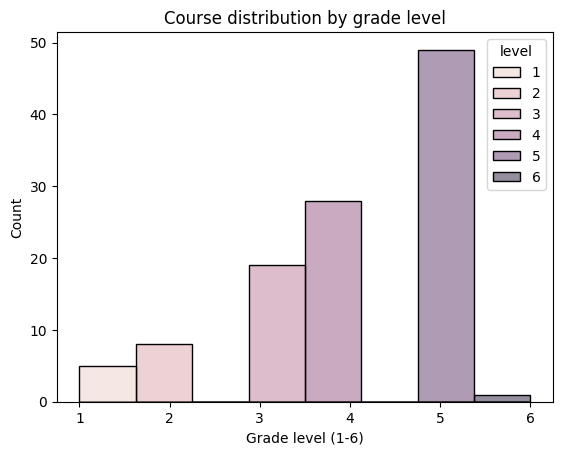

In [227]:
sns.histplot(data=course_df, x="level", hue="level")
plt.title("Course distribution by grade level")
plt.xlabel("Grade level (1-6)")
plt.show()

There is a vivid dominance in the upper year courses -- this indicates the technical courses UBC offers and how there will be major clusterings of upper year courses. We ideally hope to see more than 5-6 clusters as we want the model to detect sub-parts even within the same grade.

### 2. Data Preprocessing 

Preprocess the data to prevent garbage words from hijacking the TFIDF-Vectorizer that could put significance on words that do not represent the course itself. For description, lemmatization was applied afterwards to ensure that if there were any complex words, it would be reduced to its root form.

<strong> Description </strong>

Some courses did not have any description except the phrase, "This course is not eligible for Credit/D/Fail grading.". This is a garbage word, so the description was filled with the title instead, which best resembles the course description.

In [228]:
def clean_text(x):
    if x["description"].strip() == "This course is not eligible for Credit/D/Fail grading.":
        return x["name"]
    else:
        return x["description"]

course_df["description"] = course_df[["name", "description"]].apply(clean_text, axis=1)

<b> Pre-requisites </b> 

Using nlp(), all the related courses from the description was taken out. The course codes like CPSC or BIOL happened to be labelled as ORG, which made it easier. 

In [229]:
import spacy
nlp = spacy.load('en_core_web_sm')

def related_courses(df):
    searched = set()
    #this takes all course codes
    for i in range(1,len(df["description"])):
        text = nlp(df["description"].iloc[i])
        for j in text.ents:
            if j.label_ == "ORG" and len(j.text) == 4:
                searched.add(j.text.upper())
    return searched

all_related_courses = related_courses(course_df)

In [230]:
all_related_courses.add("BIOL")
all_related_courses.add("APSC")
all_related_courses.add("COMM")
all_related_courses.add("MATH")

Then, all the courses that were pre-requisites were taken out. This was doable as these courses always appeared after a certain pattern. After we split the pattern and the pre-requisite courses phrase, we took out the garbage words by only taking words that were one of the related courses. The course names were joined with the course number which happened to be placed in the next INDEX. These were joined by "_" to stop vectorizer from splitting them.

In [231]:
import re

pattern = r'Prerequisite|Corequisite|Not for students with existing credit for or exemption from | or currently enrolled in | Continuing .+ from | or are concurrently taking'

def return_related(phrase):
    words = set()
    split = re.split(pattern.upper(), phrase.upper())
    if len(split) > 1:
        for i in split[1:]:
            token_text = word_tokenize(i)
            for j in token_text:
                if j in all_related_courses:
                    j = "_".join((j, token_text[token_text.index(j)+1]))
                    words.add(j)
    else:
        return "NA"
    return " ".join(words)
course_df["prereq"] = course_df["description"].apply(return_related)

As a result, the pre-requisites were formatted correctly with courses with no pre-reqs being labelled with NA.

In [232]:
course_df["prereq"].iloc[1:10]

1                      CPSC_110 APSC_160
2                               CPSC_103
3                                     NA
4                               CPSC_107
5    CPSC_103 MATH_210 APSC_160 COMM_337
6                               CPSC_107
7                               CPSC_121
8                      MATH_220 CPSC_210
9                               APSC_160
Name: prereq, dtype: object

### 2.1 Scaling & Vectorizing

We will explore important keywords for description and keywords after vectorizing and scaling. RobustScaler() outperforms StandardScaler(). We decided to remove the first layer of important keywords as they were also garbage words via preprocess -- which removes the first layer of important keywords.

NOTE: You could explore to see whether removing more layers decreases the amount of garbage words by running preprocess() n times. 

In [233]:
tfv =  TfidfVectorizer(stop_words='english', lowercase=True)
scaler = RobustScaler()

def vectorize(d, vec, s):    
    res = vec.fit_transform(d)
    return s.fit_transform(res.toarray())

vectorized_description = vectorize(course_df["description"], tfv, scaler)

In [234]:
def preprocess(phrase):
    scores = pd.DataFrame(vectorized_description, columns=tfv.get_feature_names_out())
    common = np.array(scores.idxmax(axis=1))
    
    wl = WordNetLemmatizer()
    tokenized = word_tokenize(phrase)
    for word in tokenized:
        if word in common:
            tokenized.remove(word)
           
    return wl.lemmatize(" ".join(tokenized))

vectorized_description = vectorize(course_df["description"].apply(preprocess), tfv, scaler)

In [235]:
#For prereq
from sklearn.preprocessing import StandardScaler
prereq_vec = TfidfVectorizer(stop_words='english', lowercase=True)
prereq_scaler = StandardScaler()

vectorized_prereqs = vectorize(course_df[(course_df["prereq"] != " ")]["prereq"], prereq_vec, prereq_scaler)

In [236]:
tfv.get_feature_names_out()

array(['001', '101', '103', '105', '107', '110', '111', '12', '121',
       '152', '160', '200', '201', '203', '206', '210', '211', '212',
       '213', '217', '218', '220', '221', '223', '226', '231', '241',
       '250', '251', '253', '254', '259', '261', '278', '291', '300',
       '302', '303', '304', '307', '310', '311', '313', '314', '317',
       '318', '320', '321', '322', '325', '327', '328', '331', '337',
       '340', '344', '366', '371', '374', '380', '3d', '411', '491', '68',
       '72', 'abstraction', 'according', 'acquisition', 'action',
       'active', 'admitted', 'advanced', 'advisor', 'ai', 'algebra',
       'algebraic', 'algorithm', 'algorithmic', 'algorithms', 'alignment',
       'analysis', 'analytic', 'animation', 'annotation', 'application',
       'applications', 'applied', 'approach', 'approaches', 'appropriate',
       'approved', 'approximation', 'apsc', 'architecture',
       'architectures', 'area', 'areas', 'artificial', 'assessment',
       'associated'

In [237]:
prereq_vec.get_feature_names_out()

array(['apsc_160', 'biol_300', 'biol_beyond', 'bmeg_250', 'comm_291',
       'comm_337', 'cpsc_103', 'cpsc_107', 'cpsc_110', 'cpsc_121',
       'cpsc_203', 'cpsc_210', 'cpsc_213', 'cpsc_221', 'cpsc_302',
       'cpsc_304', 'cpsc_310', 'cpsc_313', 'cpsc_314', 'cpsc_320',
       'cpsc_322', 'cpsc_344', 'eece_259', 'geog_374', 'math_101',
       'math_152', 'math_200', 'math_210', 'math_220', 'math_307',
       'math_or', 'na', 'scie_001', 'stat_200', 'stat_241', 'stat_at'],
      dtype=object)

### 3. Exploring PCA, KernelPCA, TSNE for Course Description

In [238]:
from sklearn.decomposition import PCA, KernelPCA

### 3.1 PCA

<b> Explained Variance plot with PCA</b>

<Axes: >

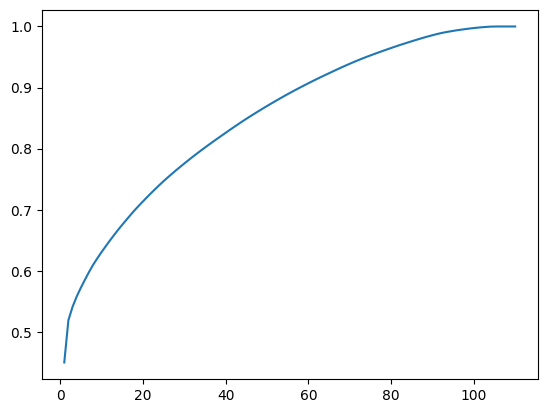

In [239]:
pca_test = PCA(n_components=110)
pca_test.fit(vectorized_description)

sns.lineplot(x=[i for i in range(1,111)], y=np.cumsum(pca_test.explained_variance_ratio_))

In [240]:
ideal_comps = 65

Refit the vectorized_description using ideal components at 65 -- near 1 explained variance.

In [241]:
pca = PCA(n_components=ideal_comps)
pca_description = pca.fit_transform(vectorized_description)

<b> Elbow Plot for Clustering Algorithms</b>

Using davies-bouldin score, we will explore the elbow plots for 3 clustering algorithms below to find the optimal n_clusters. Davies-bouldin score measures the similarity between pairs of very similar cluster. The lower it is, the better, as it indicates better seperation and cohesion between clusters and prevents overestimation.

In [242]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import davies_bouldin_score

def pca_search(param):
    chs = {}
    chs["k"] = []
    chs["agg"] = []
    chs["spec"] = []


    for i in (range(3,20)):
        kmeans = KMeans(n_clusters=i, init='k-means++',random_state=42).fit(param)
        agg = AgglomerativeClustering(n_clusters=i, linkage="ward").fit(param)
        spec = SpectralClustering(n_clusters=i, affinity="nearest_neighbors").fit(param)
        
        chs["k"].append(davies_bouldin_score(param,kmeans.labels_))
        chs["agg"].append(davies_bouldin_score(param,agg.labels_))
        chs["spec"].append(davies_bouldin_score(param,spec.labels_))
        
    
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    indices = np.arange(3,20,1)
    ax[0,0].plot(indices, list(chs["k"]), marker='o', color = 'red')
    ax[0,1].plot(indices, list(chs["agg"]), marker='o', color = 'green')
    ax[1,0].plot(indices, list(chs["spec"]), marker='o', color = 'yellow')
    
    fig.suptitle("Elbow Plot for various models - Clustering CPSC courses")
    fig.set_label("something")
    plt.show()

    pass

In [243]:
def return_optimal(optimal, param):
    label = optimal.fit_predict(param)
    u_labels = np.unique(label) #all clusters
    plt.figure()
    
    #Cluster plot
    for i in u_labels:
        plt.scatter(param[label == i , 0] , param[label == i , 1] , label = i)
    
    #Centroids
    if type(optimal).__name__ == "KMeans":
        centroids = optimal.cluster_centers_
        plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.legend()
    plt.show()
    
    with_label = pd.concat([course_df, pd.DataFrame(label)], axis=1)
    return [optimal, with_label]

#### PCA Elbow Plot 

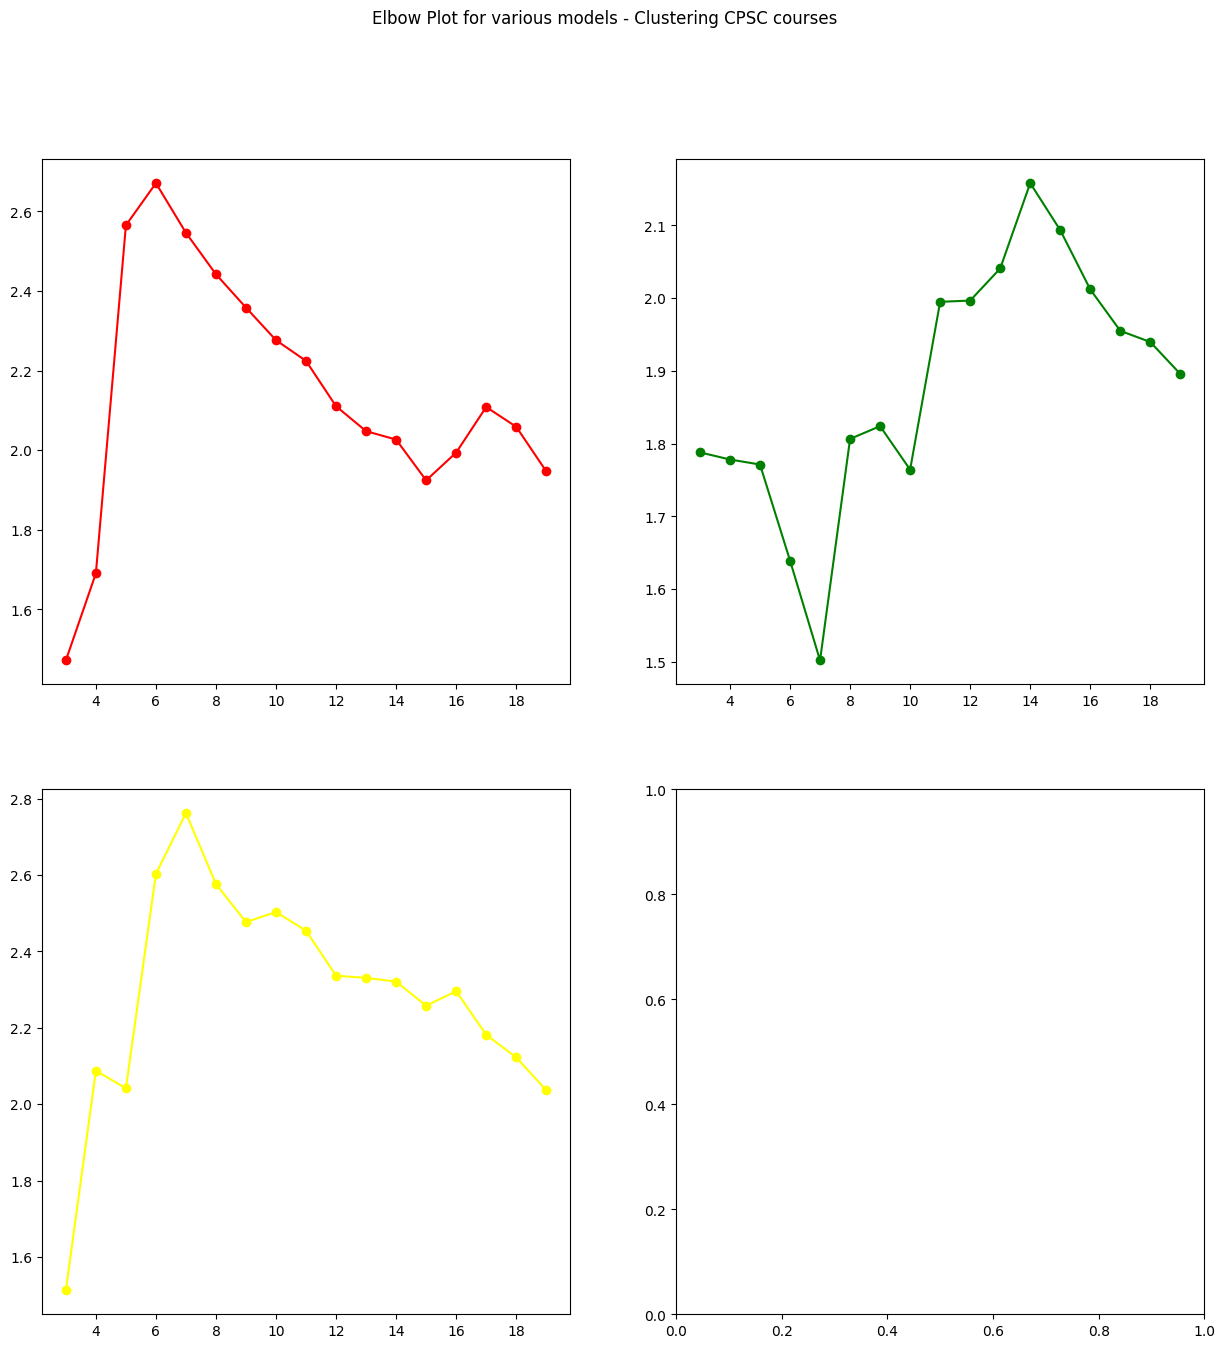

In [244]:
pca_search(pca_description)

#### Optimal model - PCA

Spectral Clustering + PCA seems to seems to yield the best result. While the elbow plot has fluctuations in the beginning, it linearly decreases arfter the 7th cluster. A trade for fluctuation for little inaccuracy is reasonable, as fluctuations is unreliable due to ambiguous clustering done due to noise. The score for KMeans and Agglomerative clustering models increase at random points, making it hard to pick an optimal.

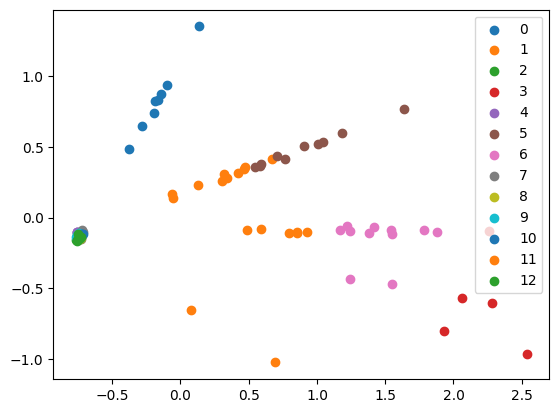

In [245]:
agg, with_label = return_optimal(SpectralClustering(n_clusters = 13, affinity="nearest_neighbors"), pca_description)

### 3.2 KernalPCA 

In [277]:
pca_2 = KernelPCA(n_components=ideal_comps, kernel="rbf")
pca_description_2 = pca_2.fit_transform(vectorized_description)

#### KernelPCA Elbow Plot 

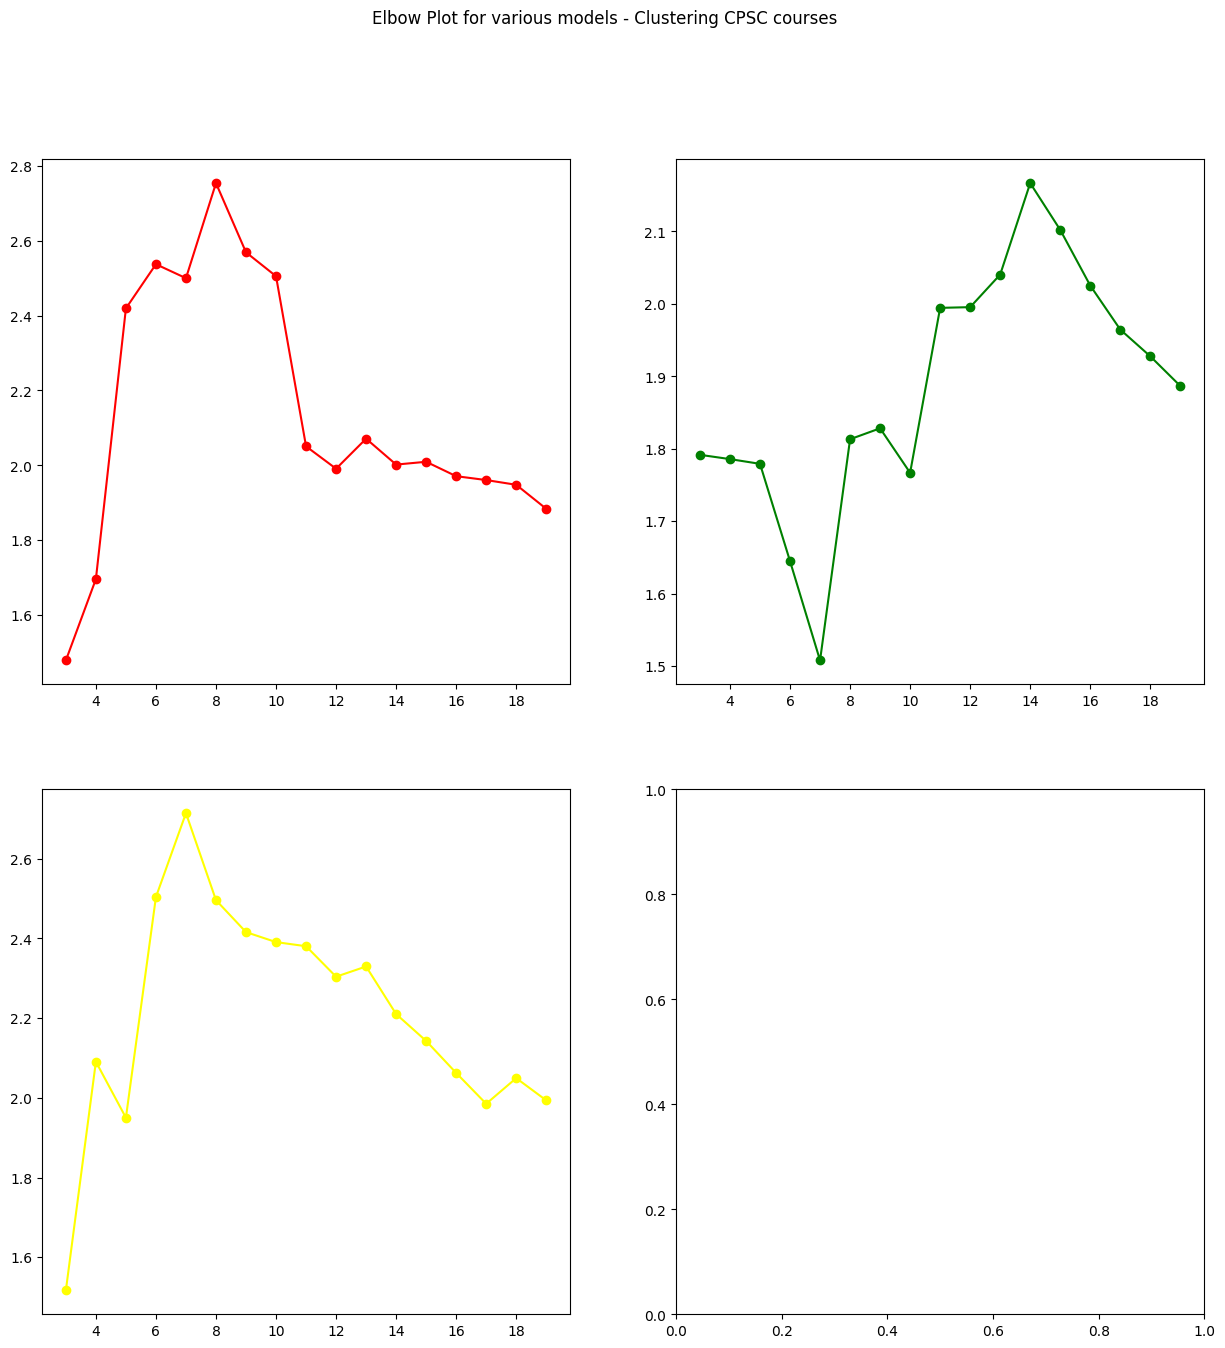

In [278]:
pca_search(pca_description_2)

### Optimal model - KernelPCA

Only KMeans has a non-fluctuating curve along with an elbow and a reasonable davies-bouldin score. Other plots indicate fluctuation, which can be interpreted as inconsistency, lack of clear decision point, and inability to capture the data noise. 

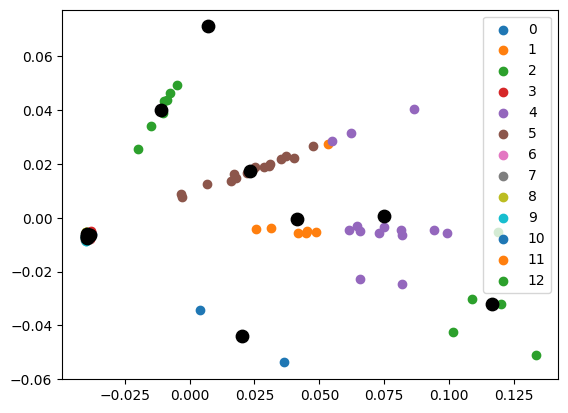

In [279]:
kmeans_2, with_label_2 = return_optimal(KMeans(n_clusters=13, init="k-means++", max_iter=500, random_state=18), pca_description_2)

### 3.3 TSNE

In [249]:
from sklearn.manifold import TSNE
pca_3 = TSNE(n_components=2)
pca_description_3 = pca_3.fit_transform(vectorized_description)

#### TSNE Elbow Plot

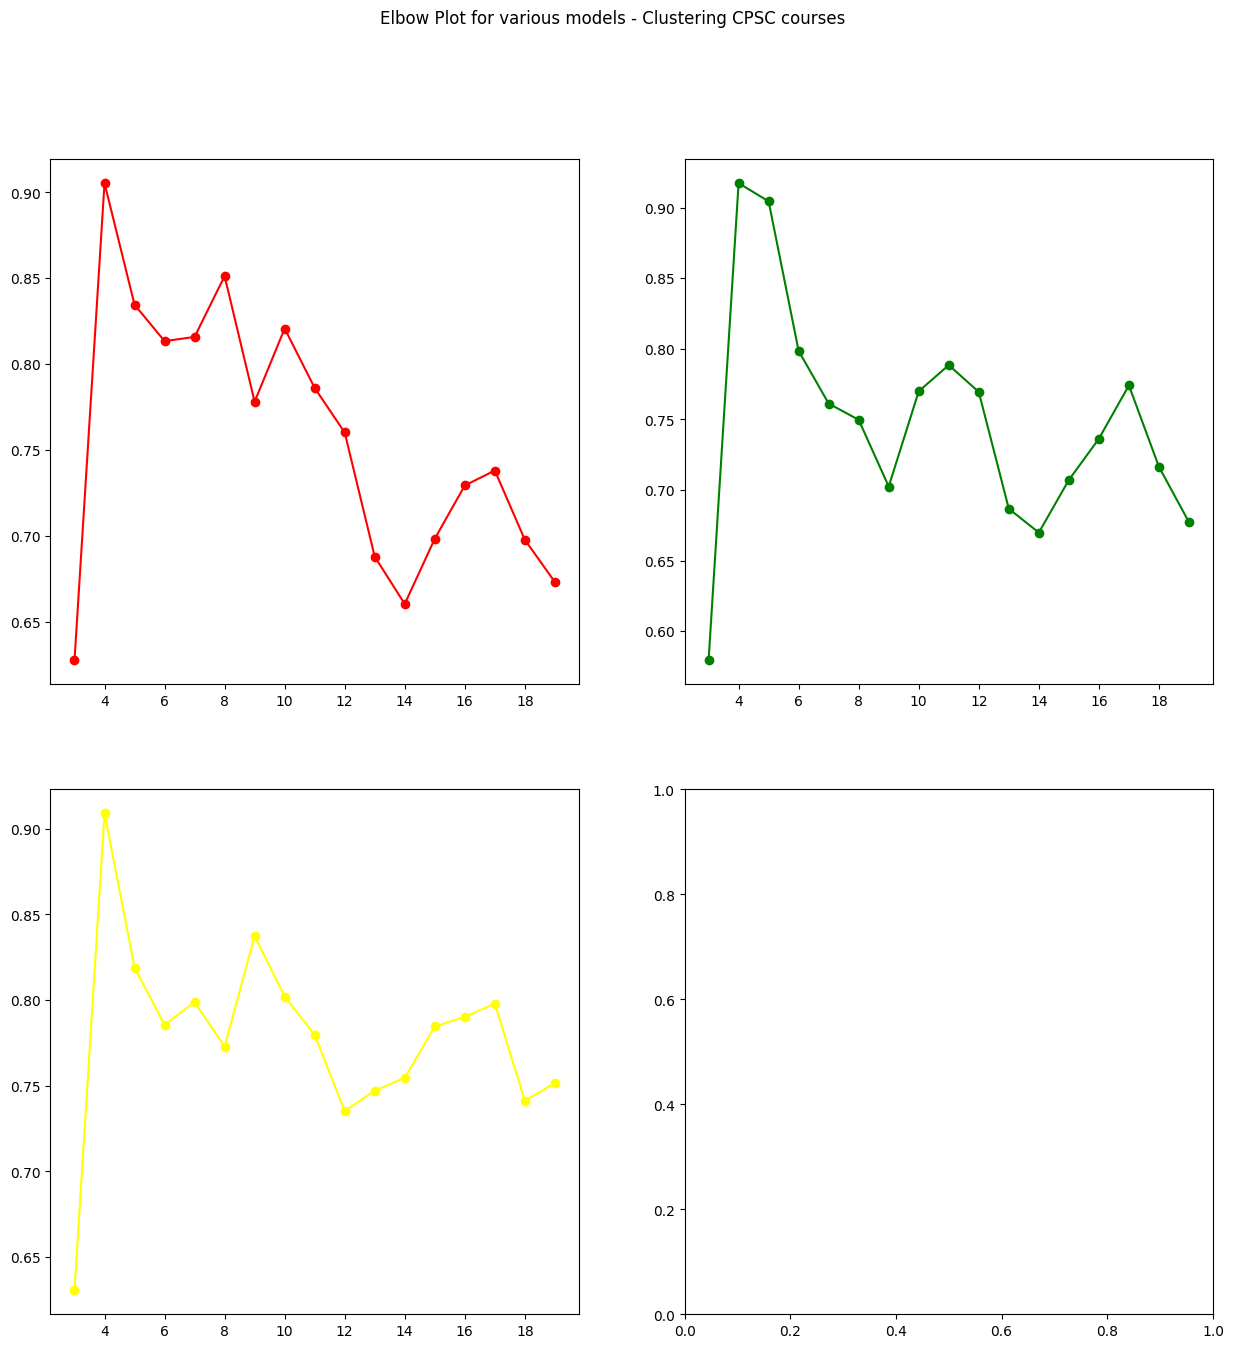

In [250]:
pca_search(pca_description_3)

### Optimal model - TSNE

For TSNE, it is difficult to find an optimal. The model with the lowest fluctuations and consistent decrease of davies-bouldin score seems to be Agglomerative clustering. However, seen from the visualization below, the clusters are not performing as well compared to PCA and KernelPCA methods.  

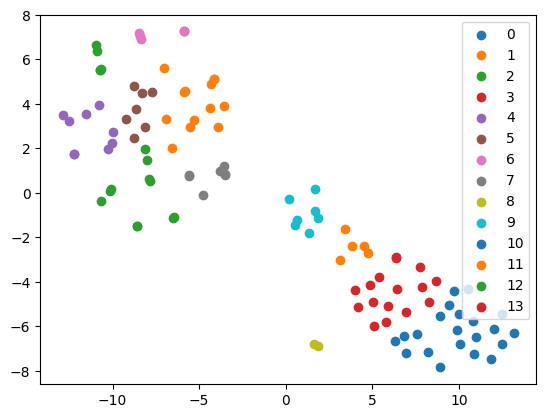

In [267]:
kmeans_3, with_label_3 = return_optimal(AgglomerativeClustering(n_clusters=14, linkage="ward"), pca_description_3)

While all reduction techniques are reasonably accurate, TSNE seems to have the most cohesive cluster at davies-bouldin score of ~0.75 whereas other 2 techniques yielded similarly around 1.5.

<b> Initial & Final dimensions </b>

In [252]:
print(f"Initial PCA dimension: {np.min([vectorized_description.shape[0], vectorized_description.shape[1]])}.")
print(f"Final PCA dimension: {pca_description.shape[1]}.")

Initial PCA dimension: 110.
Final PCA dimension: 65.


## 4. Pre-requisites

In [253]:
vectorized_prereqs

array([[ 4.89906354, -0.13605406, -0.09578263, ..., -0.13173975,
        -0.09578263, -0.09578263],
       [ 4.49046153, -0.13605406, -0.09578263, ..., -0.13173975,
        -0.09578263, -0.09578263],
       [-0.18673331, -0.13605406, -0.09578263, ..., -0.13173975,
        -0.09578263, -0.09578263],
       ...,
       [-0.18673331, -0.13605406, -0.09578263, ..., -0.13173975,
        -0.09578263, -0.09578263],
       [-0.18673331, -0.13605406, -0.09578263, ..., -0.13173975,
        -0.09578263, -0.09578263],
       [-0.18673331, -0.13605406, -0.09578263, ..., -0.13173975,
        -0.09578263, -0.09578263]])

### 4.1 Fit data using dim-reduction techniques

In [254]:
pca_reqs_tsne = TSNE(n_components=2)
pca_prereqs_tsne = pca_reqs_tsne.fit_transform(vectorized_prereqs)

pca_reqs_kernel = KernelPCA(n_components=30, kernel="rbf")
pca_prereqs_kernel = pca_reqs_kernel.fit_transform(vectorized_prereqs)

pca_reqs = PCA(n_components=30)
pca_prereqs = pca_reqs.fit_transform(vectorized_prereqs)

<b> Corresponding Elbow Plots </b>

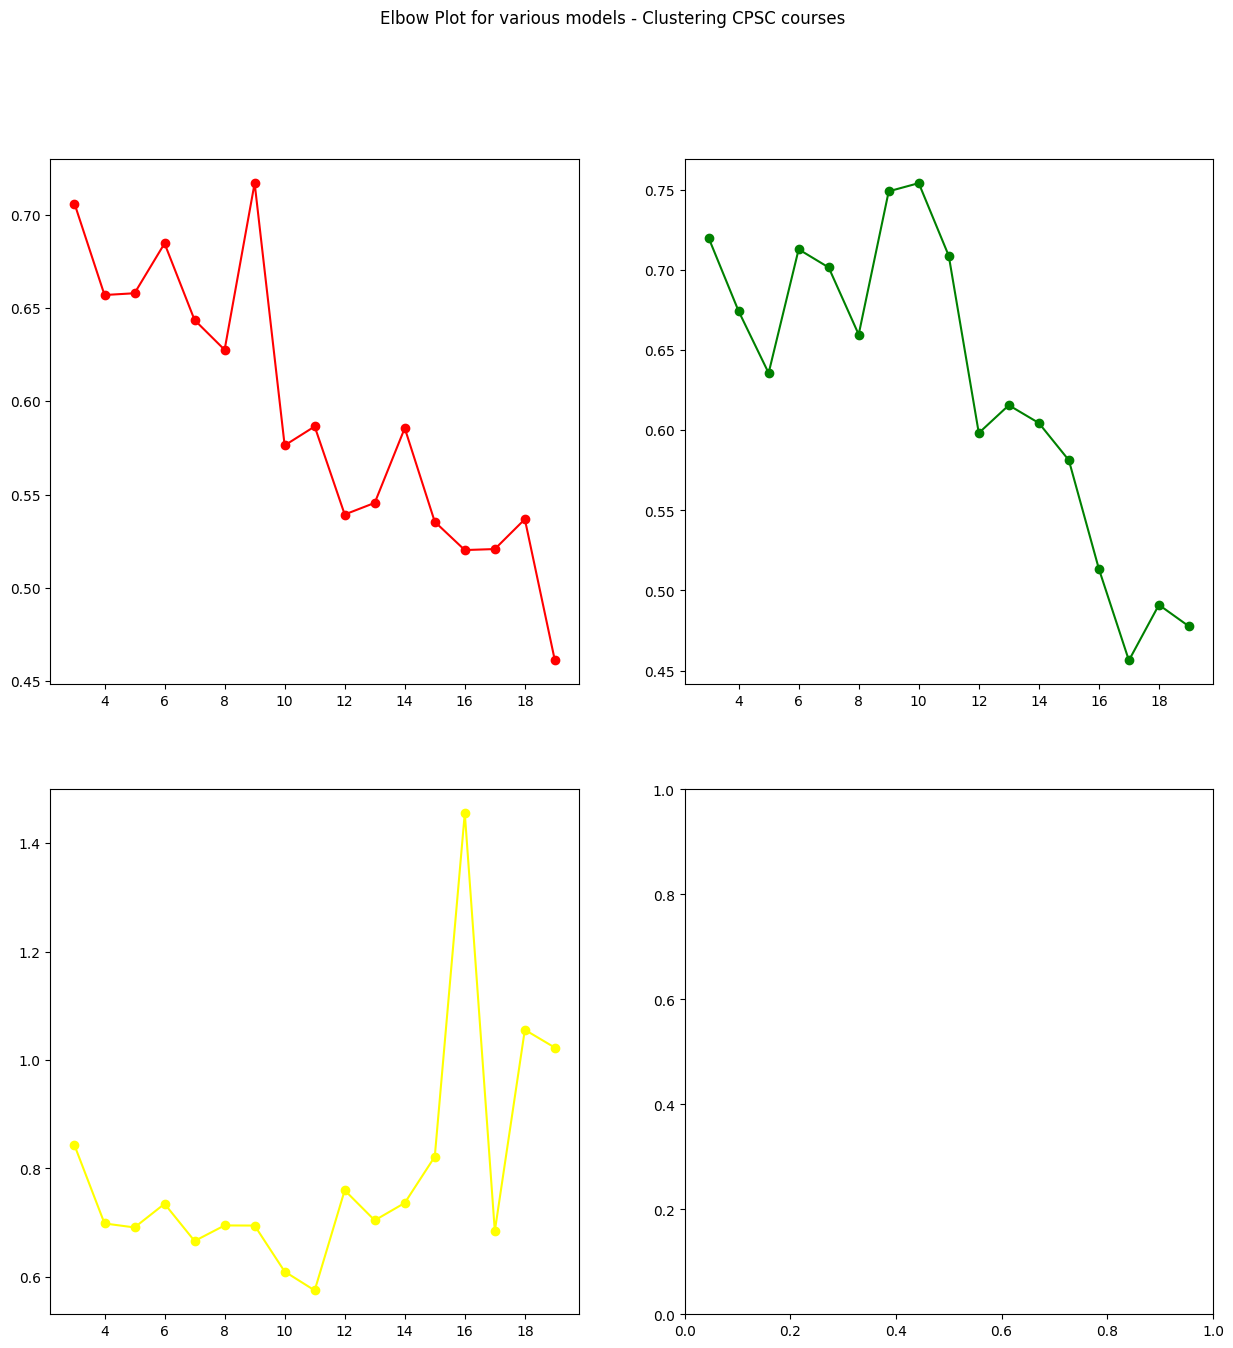

In [255]:
pca_search(pca_prereqs_tsne)

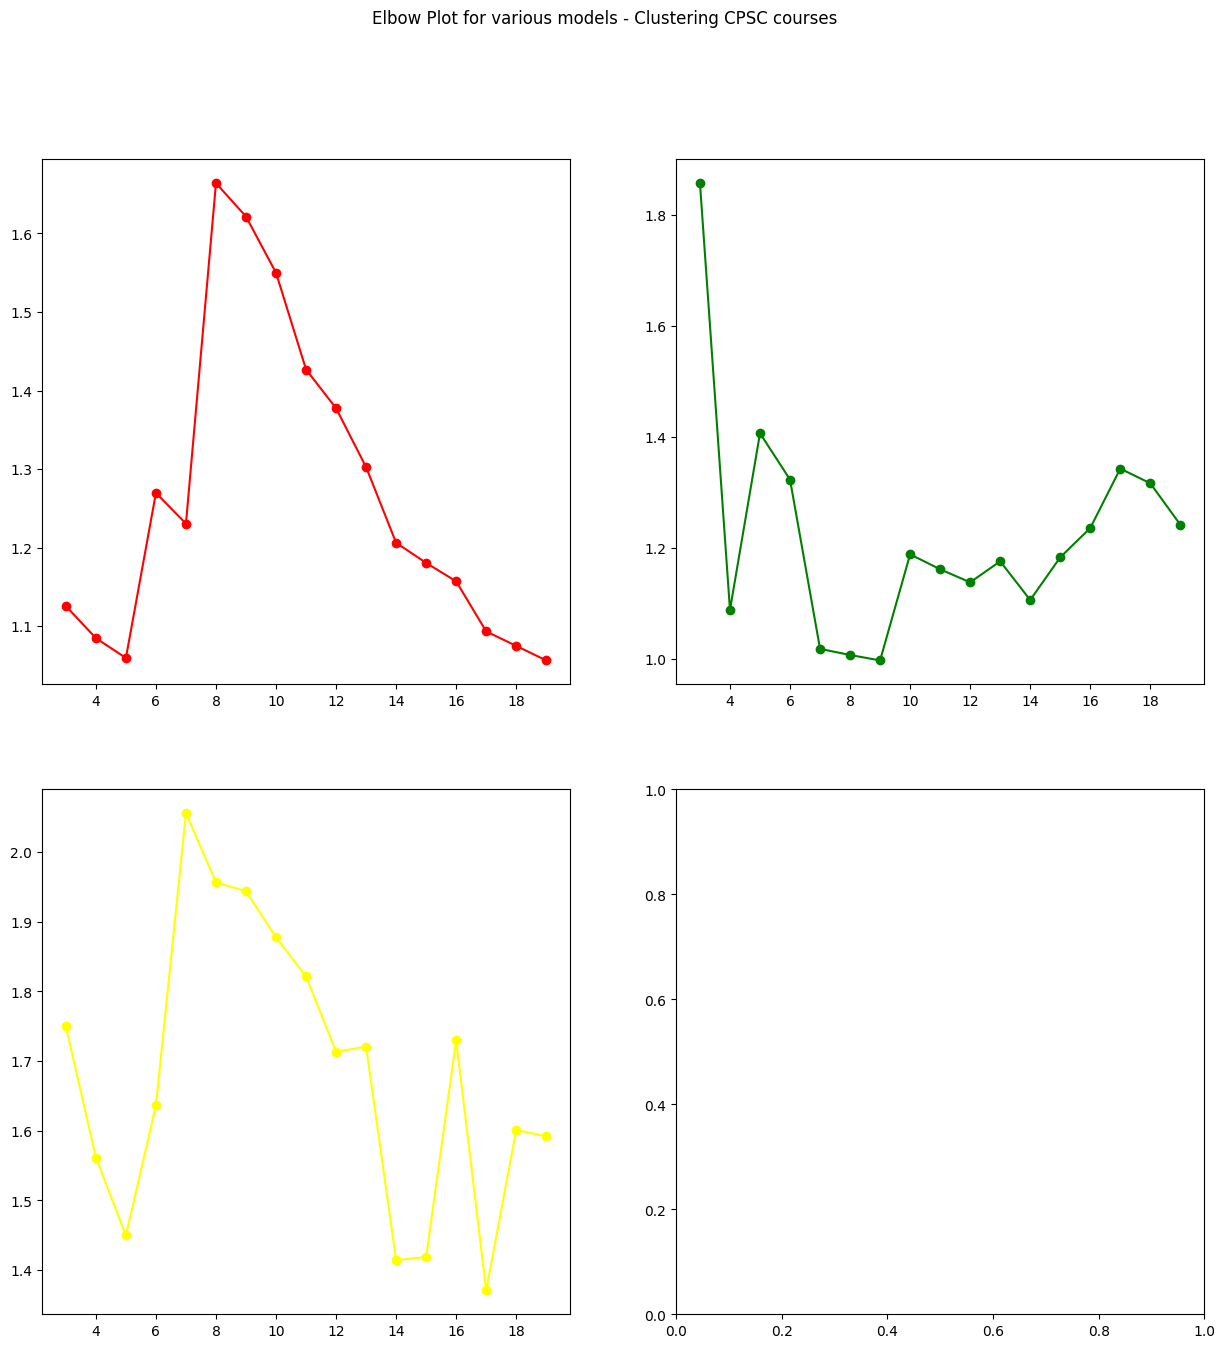

In [256]:
pca_search(pca_prereqs_kernel)

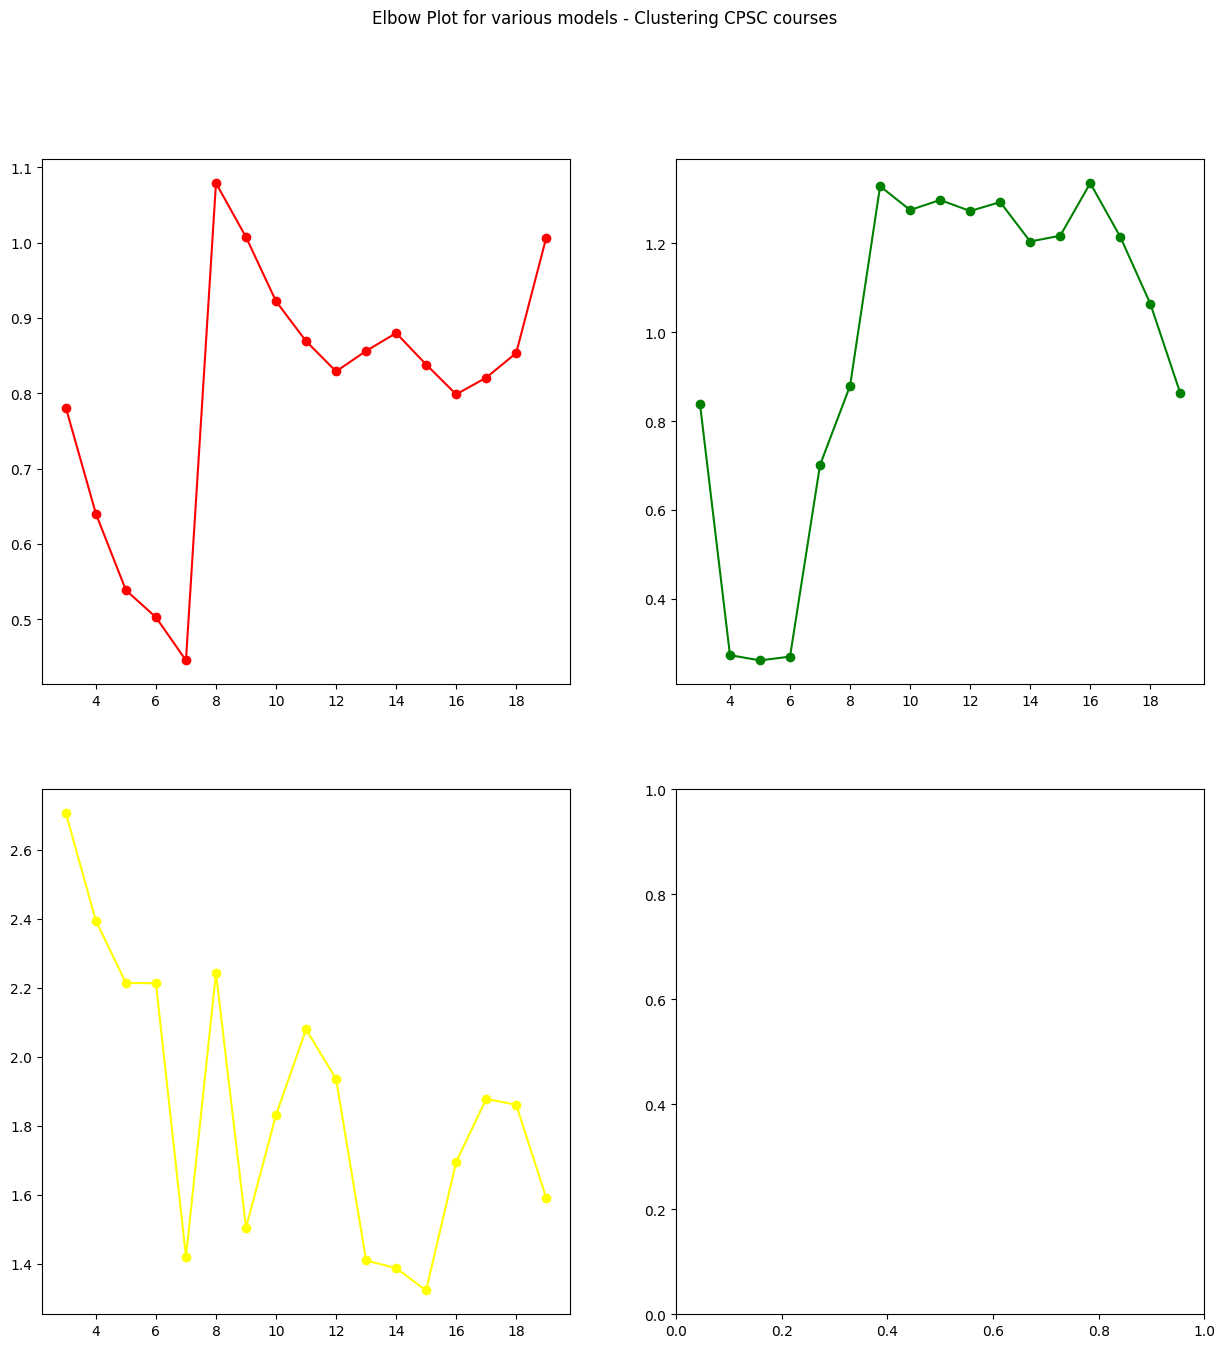

In [257]:
pca_search(pca_prereqs)

#### Optimal for Pre-requisites

From the 3 plots above, each of the 3 clustering algorithms have their own dropping point with a non-extreme n_cluster. Although, the KMeans + TSNE combination seems to resemble the elbow shape the most with davies-bouldin only slowly decreasing with higher clusters. Other clustering methods fluctuate and do not have a clear decision point. KMeans + TSNE also has a significant drop point with the score still somewhat decreasing afterwards.

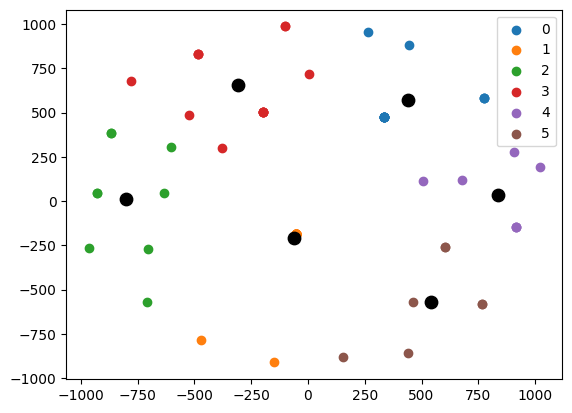

In [258]:
kmeans_4,with_label_4 = return_optimal(KMeans(n_clusters=6, init="k-means++"), pca_prereqs_tsne)


### 5. Recommendation Function

We will cosntruct a recommend function that will recommend courses based on description and pre-requisites. The general idea is predict which cluster does the input (keyword) belongs in and return courses that also belong in the same cluster. As a caveat, TSNE, Spectral and Agglomerative clustering can't apply .transform() or .predict() function respectively. Hence, when choosing those models, similar courses based on user-based description doens't work -- only pre-requisites or similar courses based on names work.

In [259]:
def recommend(keyword, by_desc, by_req, pca_model, cluster_model):
    try:
        if len(keyword) > 0:
            input = pd.Series(keyword.lower())
            if by_desc:
                processed = pca_model.transform(tfv.transform(input))
                pred = cluster_model.predict(processed)[0]
                print(f"Belongs to: {pred}-th cluster.")
                print(with_label_2[with_label_2[0] == pred].sample(3)[["code", "name"]])
            elif by_req:
                print(with_label_4[with_label_4["prereq"].str.find(keyword) != -1][["code", "description", 0]].head(5))
        else:
            raise Exception("No input")
    except Exception as err:
        print(err)

#### Description-based recommendation

<b> Co-op courses </b>

In [286]:
recommend("Approved and supervised technical work experience", True, False, pca_2, kmeans_2)

Belongs to: 8-th cluster.
            code                             name
30   CPSC_V 398   Co-operative Work Placement III
59   CPSC_V 499     Co-operative Work Placement V
103  CPSC_V 549                   Master's Thesis


<b> Software courses </b>

In [287]:
recommend("software engineering", True, False, pca_2, kmeans_2)

Belongs to: 3-th cluster.
            code                          name
80   CPSC_V 524   Computer Graphics: Modelling
75   CPSC_V 517      Sparse Matrix Computation
101  CPSC_V 547      Information Visualization


<b> CV & Animation courses </b>

In [288]:
recommend("animation graphics computer",True, False, pca_2, kmeans_2)

Belongs to: 9-th cluster.
            code                                     name
92   CPSC_V 537   Topics in Coding and Information Theory
86   CPSC_V 531           Topics in Theory of Computation
105  CPSC_V 554      Topics in Human-Computer Interaction


<b> Course teaching Voronoi diagram / Markov chains </b>

In [289]:
recommend("voronoi markov abstraction",True, False, pca_2, kmeans_2)

Belongs to: 3-th cluster.
            code                                          name
106  CPSC_V 564                                    Data Mining
64   CPSC_V 504                                Data Management
77   CPSC_V 520   Numerical Solution of Differential Equations


<b> Machine Learning courses </b>

In [290]:
#ML courses
recommend("Machine learning",True, False, pca_2, kmeans_2)

Belongs to: 3-th cluster.
           code                                          name
63  CPSC_V 503                    Computational Linguistics I
77  CPSC_V 520   Numerical Solution of Differential Equations
67  CPSC_V 507                           Software Engineering


#### Pre-requisite-based recommendation

<b> Courses that has CPSC 221 as pre-reqs </b>

In [265]:
recommend("CPSC_221",False, True, pca_reqs_tsne, kmeans_3)

           code                                        description  0
15  CPSC_V 304   Overview of database systems, ER models, logic...  4
20  CPSC_V 314   Human vision and colour; geometric transformat...  3
23  CPSC_V 320   Systematic study of basic concepts and techniq...  3
24  CPSC_V 322   Problem-solving and planning; state/action mod...  4
26  CPSC_V 340   Models of algorithms for dimensionality reduct...  4


<b> Courses that has CPSC 210 as pre-reqs </b>

In [266]:
#Courses that has CPSC_210 as pre-reqs.
recommend("CPSC_210",False, True, pca_reqs_tsne, kmeans_3)

           code                                        description  0
8   CPSC_V 221   Design and analysis of basic algorithms and da...  4
17  CPSC_V 311   Comparative study of advanced programming lang...  0
18  CPSC_V 312   Principles of symbolic computing, using langua...  0
27  CPSC_V 344   Basic tools and techniques, teaching a systema...  0


### 6. Results

- Seen from the recommendation function, given a short phrase or pre-requisite courses, the output seems to be generally correct (validated from CPSC course page). 
- Based on description keywords, there is a clear distinction between clusters. For example, the model was able to well distinguish between Co-op courses vs Machine learning courses. Optimizing the elbow plots based on Davies-Bouldin score turned out more effective than using simple inertia, since more complex scoring system measures not only cohesion but also seperation and similarity scores. 
- For description, TSNE was not effective compared to KernelPCA / PCA.  

- For pre-reqs, the TSNE had the cleanest clusters. 
- Identifying courses with pre-requisite keyword couldn't be more accurate. Not only are the results correct (verified from course page), the courses with the same combination of pre-requisites are well distinguished from courses that has a subset of those pre-requisites (i.e. course with CPSC and MATH ≠ course with CPSC).


*Future Inquiries:*
1. Optimizing with other clustering models and PCA models.
2. Deeper preprocessing words -- on top of vectorizing & scaling, try deep-searching for words that are really important via tokenization or other NLP techniques.
3. Testing different scoring systems such as calinski-harabasz index. 
4. Turn it into a Classification problem through data labelling -- more time consuming.